# Download and visualize urban data

In [1]:
import sys
sys.path.append('..')
import urbanpy as up

import warnings
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm, tqdm_notebook

In [2]:
warnings.filterwarnings("ignore")

In [3]:
tqdm.pandas()
tqdm_notebook().pandas()

## Downloading data for different cities and plotting

In [4]:
ba = up.download.nominatim_osm('Buenos Aires, Argentina') # expected_position is 0 by default

In [5]:
quito = up.download.nominatim_osm('Quito, Ecuador', 2) # second result

In [4]:
lima = up.download.nominatim_osm('Lima, Peru', 2) # third result

NameError: name 'ba' is not defined

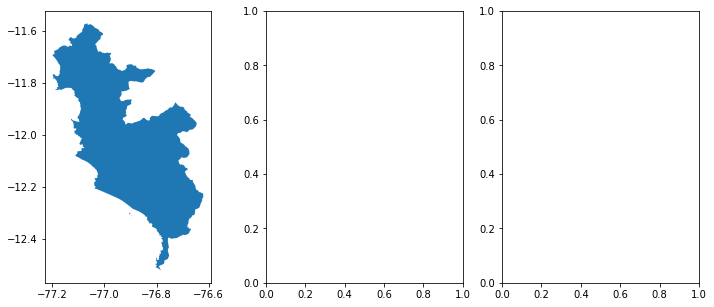

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

lima.plot(ax=ax1)
ba.plot(ax=ax2)
quito.plot(ax=ax3)

plt.tight_layout()

Lima is still missing the Callao polygon, lets download it as well

In [5]:
callao = up.download.nominatim_osm('Callao, Peru', 1)

Now we easily can marge lima and callao polygons

In [6]:
lima = up.geom.merge_geom_downloads([lima, callao])

<AxesSubplot:>

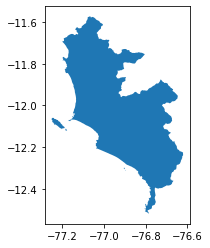

In [7]:
lima.plot()

### Downloading population data

In [11]:
pop_arg = up.download.hdx_fb_population('argentina', 'full')

In [12]:
pop_ecu = up.download.hdx_fb_population('ecuador', 'full')

In [13]:
pop_per = up.download.hdx_fb_population('peru', 'full')

In [14]:
pop_per.head()

,latitude,longitude,population_2015,population_2020
0,-18.339306,-70.382361,11.318147,12.099885
1,-18.335694,-70.393750,11.318147,12.099885
2,-18.335694,-70.387361,11.318147,12.099885
3,-18.335417,-70.394028,11.318147,12.099885
4,-18.335139,-70.394306,11.318147,12.099885


### Conversion to Point geometries and hexagons

We got the lat lon coordinates but their are just in numerical format, we need them as geometries to perform spatial operations on the hexagon grid

First, lets filter the national population to our city bounds

In [15]:
pop_ba = up.geom.filter_population(pop_arg, ba)

In [16]:
pop_quito = up.geom.filter_population(pop_ecu, quito)

In [17]:
pop_lima = up.geom.filter_population(pop_per, lima)

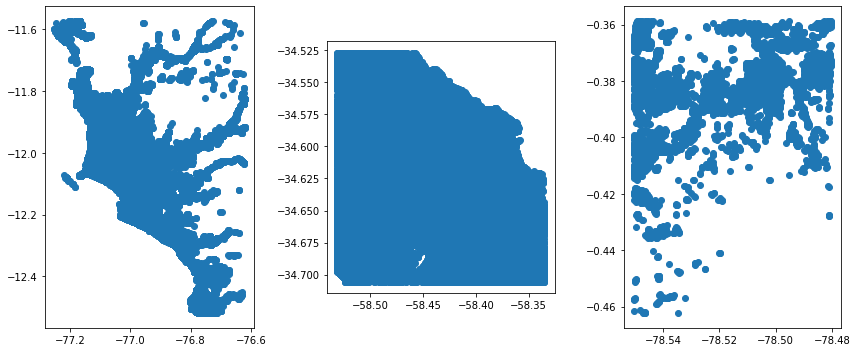

In [18]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

pop_lima.plot(ax=ax1)
pop_ba.plot(ax=ax2)
pop_quito.plot(ax=ax3)

plt.tight_layout()

Applying filter_population gives us the set of points within our city's bounds and a Point geometry to work with hexagons

### Removing unnecesary features

We don't need the San Lorenzo island. By providing a bounding box we an remove it

In [19]:
pop_lima = up.geom.remove_features(pop_lima, [-77.3, -12.2, -77.17, -12])

<AxesSubplot:>

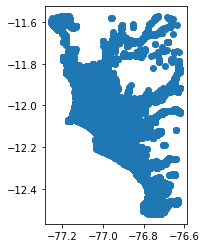

In [20]:
pop_lima.plot()

Let's generate the hexagon grid using Uber's H3

In [21]:
hex_ba = up.geom.gen_hexagons(9, ba)

In [22]:
hex_ba.shape

(2810, 2)

In [23]:
hex_quito = up.geom.gen_hexagons(10, quito)

In [24]:
hex_quito.shape

(1226, 2)

In [8]:
hex_lima = up.geom.gen_hexagons(8, lima)

In [9]:
hex_lima.shape

(3301, 2)

Notice the effect of the resolution parameter (higher resolution values generate smaller hexagons)

### Merging a layer

We got both the population point geometries and hexagons, lets get the population per hexagon.

In [27]:
hex_ba = up.geom.merge_shape_hex(hex_ba, pop_ba, agg={'population_2020':'sum', 'population_2015':'mean'})

In [28]:
hex_quito = up.geom.merge_shape_hex(hex_quito, pop_quito, agg={'population_2020':'sum', 'population_2015':'mean'})

In [8]:
hex_lima = up.geom.merge_shape_hex(hex_lima, pop_lima, agg={'population_2020':'sum', 'population_2015':'mean'})

NameError: name 'hex_lima' is not defined

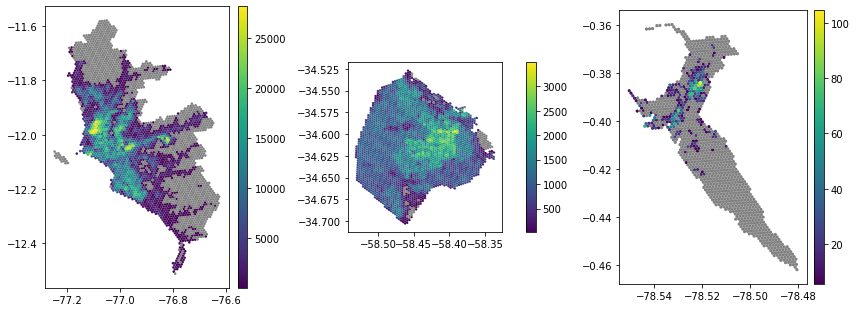

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
hex_lima.plot('population_2020', legend=True, missing_kwds={'color':'grey'}, ax=ax1, cax=cax1)

divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
hex_ba.plot('population_2020', legend=True, missing_kwds={'color':'grey'}, ax=ax2, cax=cax2)

divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
hex_quito.plot('population_2020', legend=True, missing_kwds={'color':'grey'}, ax=ax3, cax=cax3)

plt.tight_layout()

We've used an inner join to keep only the points that intersect a hexagon (in this case, a within operation gives similar results). We provide a dictionary detailing how to aggregate our fields of interest

## Calculate trip distance and duration from each hexagon to the closest food facility

In [10]:
hex_lima['lat'] = hex_lima.geometry.centroid.y
hex_lima['lon'] = hex_lima.geometry.centroid.x

In [11]:
fs = up.download.overpass_pois(bounds=lima.total_bounds, facilities='food')

<AxesSubplot:>

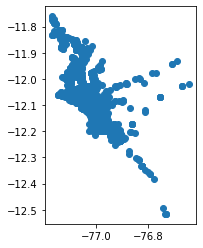

In [12]:
fs.plot()

Neighborhood search to find closest food facility

In [13]:
dist_up, ind_up = up.utils.nn_search(
    tree_features=fs[['lat', 'lon']].values, # Point of Interest
    query_features=hex_lima[['lat', 'lon']].values, # Spatial Unit (Hexagons) Centroid
    metric='haversine' # Distance metric
)

In [14]:
hex_lima['nearest_food_facility_ix'] = ind_up

Use OSRM routing server to find walking distance and duration 

In [15]:
# start server
up.routing.start_osrm_server('peru', 'south-america', "foot")

Server is already running.


In [17]:
# Distancia y duración del viaje a pie
distance_duration = hex_lima.progress_apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid, 
        destination = fs.iloc[row['nearest_food_facility_ix']]['geometry']
    ),
    result_type='expand',
    axis=1,
)

In [18]:
hex_lima['distance_to_food_facility'] =  distance_duration[0] / 1000 # meters to km
hex_lima['duration_to_food_facility'] = distance_duration[1] / 60 # seconds to minutes

In [19]:
up.routing.stop_osrm_server('peru', 'south-america')

TypeError: stop_osrm_server() missing 1 required positional argument: 'profile'

## Generate interactive maps

In [ ]:
fig = up.plotting.choropleth_map(hex_lima, 'population_2020', title='Estimated Population - 2020', 
                                 width=400, height=400)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()

Binarize durations to improve map visualization 

In [42]:
custom_bins, custom_labels = up.utils.create_duration_labels(hex_lima['duration_to_food_facility'])

In [43]:
hex_lima['duration_to_food_facility_bins'] = pd.cut(hex_lima['duration_to_food_facility'], bins=custom_bins, labels=custom_labels)

You can customize your plot usign the plotly.express.choropletmap function parameters

In [ ]:
fig = up.plotting.choropleth_map(
    hex_lima, 'duration_to_food_facility_bins',
    title='Acceso a instalaciones de venta de alimento',
    color_discrete_sequence=px.colors.sequential.Plasma_r, 
    category_orders={'duration_to_food_facility_bins': custom_labels}, 
    width=400, height=400
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
)

fig.show()